In [3]:
import os
import random
import numpy as np
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.utils import shuffle
from sklearn.neural_network import MLPClassifier
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from read_eeg import get_eeg_info
from scipy.signal import welch

In [4]:
def read_egg(path):
    mat = scipy.io.loadmat(path)
    eeg = mat['transferred_EEG']['trial'][0,0][0,0]  # first trial
    return eeg

In [7]:
# --- Parameters ---
healthy_folder = 'C:/Users/Haiya/Downloads/Data_EEG/Data_EEG/Healthy/'
ad_folder = 'C:/Users/Haiya/Downloads/Data_EEG/Data_EEG/AD/'

fs = 500
min_samples = int(1.0 * 60 * fs)
max_samples = int(1.0 * 60 * fs)
num_segments = 7

# --- File Loading ---
ad_files = [f for f in os.listdir(ad_folder)]
healthy_files = [f for f in os.listdir(healthy_folder)]

random.seed(1)
random.shuffle(ad_files)
random.shuffle(healthy_files)

AD_data = {}
heal_data = {} 

for i in ad_files: 
    egg = read_egg(ad_folder + i)
    AD_data[i + '_AD'] = egg

for i in healthy_files: 
    egg = read_egg(healthy_folder + i)
    heal_data[i+ '_healthy'] = egg

In [8]:
def split_dict_with_sklearn(data_dict, seed=42):
    keys = list(data_dict.keys())

    # First: split into train (80%) and temp (20%)
    train_keys, temp_keys = train_test_split(keys, test_size=0.4, random_state=seed)

    # Second: split temp into val (10%) and test (10%)
    val_keys, test_keys = train_test_split(temp_keys, test_size=0.5, random_state=seed)

    # Reconstruct dictionaries
    train = {k: data_dict[k] for k in train_keys}
    val   = {k: data_dict[k] for k in val_keys}
    test  = {k: data_dict[k] for k in test_keys}
    return train, val, test

In [9]:
# Apply to each class
ad_train, ad_val, ad_test = split_dict_with_sklearn(AD_data)
hl_train, hl_val, hl_test = split_dict_with_sklearn(heal_data)

# Combine class-wise splits
train_rd = {**ad_train, **hl_train}
val_rd   = {**ad_val, **hl_val}
test_rd  = {**ad_test, **hl_test}

print(f"Train size: {len(train_rd)}, Val: {len(val_rd)}, Test: {len(test_rd)}")

Train size: 19, Val: 6, Test: 7


In [10]:
def segment_subjects(data_dict, num_segments=7, drop_remainder=True):
    """
    Split each subject’s EEG into `num_segments` contiguous chunks of equal length.

    Parameters
    ----------
    data_dict : dict[str, np.ndarray]
        Keys are subject IDs, values are EEG arrays shaped (n_channels, n_samples).
    num_segments : int, default 7
        How many equal-sized chunks to create.
    drop_remainder : bool, default True
        If total_samples is not exactly divisible by `num_segments`,
        drop the trailing leftover when True;
        otherwise let the final segment absorb the remainder.

    Returns
    -------
    segments : list[np.ndarray]
        EEG chunks of shape (n_channels, seg_len).
    labels : list[int]
        1 if the subject key contains “_AD”, else 0.
    """
    segments, labels = [], []

    for k, eeg in data_dict.items():
        n_ch, total = eeg.shape
        seg_len = total // num_segments
        if seg_len == 0:
            raise ValueError(f"'{k}' has too few samples ({total}) for {num_segments} segments.")

        # Determine how many samples each segment will actually take
        lengths = [seg_len] * num_segments
        if not drop_remainder:
            # give the remainder to the last segment
            lengths[-1] += total - seg_len * num_segments

        start = 0
        for length in lengths:
            end = start + length
            if end > total:          # happens only when drop_remainder=True
                break
            segments.append(eeg[:, start:end])
            labels.append(1 if "_AD" in k else 0)
            start = end

    return segments, labels


In [99]:
#bands = {'Delta': (1, 4), 'Theta': (4, 8), 'Alpha': (8, 13), 'Beta': (13, 30), 'Gamma': (30, 70)}
def extract_features(eeg_data, fs):
    features = []
    for seg in eeg_data:
        feature = [] 
        for ch in seg:
            #f, pxx = welch(ch, fs=fs, window='hamming', nperseg=512, noverlap=256, nfft=512) # sliding window that has size of 256 units. 
            #print(np.array(ch).shape)
            feature.append(np.array(ch)[: 28000])
        features.append(np.array(feature))
    print(np.array(features).shape)
    return np.array(features)

In [102]:
# --- Process Data ---
train_data, train_labels = segment_subjects(train_rd, num_segments)
val_data, val_labels = segment_subjects(val_rd, num_segments)
test_data, test_labels = segment_subjects(test_rd, num_segments)

# Balance train set to make both == 
#train_data, train_labels = shuffle(train_data, train_labels, random_state=1)
#ad_idx = [i for i, l in enumerate(train_labels) if l == 1]
#hl_idx = [i for i, l in enumerate(train_labels) if l == 0]
#min_class = min(len(ad_idx), len(hl_idx))
#sel_idx = ad_idx[:min_class] + hl_idx[:min_class]
#train_data = [train_data[i] for i in sel_idx]
#train_labels = [train_labels[i] for i in sel_idx]

# Feature extraction
train_features = extract_features(train_data, fs)
val_features = extract_features(val_data, fs)
test_features = extract_features(test_data, fs)

(133, 19, 28000)
(42, 19, 28000)
(49, 19, 28000)


In [103]:
print(train_features.shape, val_features.shape, test_features.shape)

(133, 19, 28000) (42, 19, 28000) (49, 19, 28000)


In [106]:
print(len(train_labels), len(val_labels), len(test_labels))

133 42 49


In [108]:
print(np.max(train_features))

345.9105


### Mix data

In [110]:
import numpy as np
import torch
from torch.utils.data import Dataset

# -----------------------------------------------------------
# 1.  Gather the original data into a single pool
# -----------------------------------------------------------
# shapes: (133,19,257) , (42,19,257) , (49,19,257)
#features = np.concatenate([train_features, val_features, test_features], axis=0).astype(np.float32)
#labels   = np.concatenate([train_labels,  val_labels,  test_labels ]).astype(np.int8)
#n_orig   = features.shape[0]            # 224 samples total


# -----------------------------------------------------------
# 2.  On-the-fly mixed dataset (saves RAM)
# -----------------------------------------------------------
class MixedEEGDataset(Dataset):
    """
    Each item is built by taking:
        • first 10 channels  from sample A
        • last  9 channels   from sample B
    New label = A_label + 2 * B_label  ∈ {0,1,2,3}
    """
    def __init__(self, base_feats, base_lbls, length=100_000, seed=None):
        self.base_feats = torch.as_tensor(base_feats)  # (N,19,257)
        self.base_lbls  = torch.as_tensor(base_lbls, dtype=torch.long)
        self.length     = length

        rng = np.random.default_rng(seed)
        self.idx_A = rng.integers(0, len(base_lbls), size=length)
        self.idx_B = rng.integers(0, len(base_lbls), size=length)

    def __len__(self):
        return self.length

    def __getitem__(self, i):
        A = self.base_feats[self.idx_A[i]]
        B = self.base_feats[self.idx_B[i]]

        mixed = torch.cat((A[:10], B[10:]), dim=0)       # 19×257
        label = self.base_lbls[self.idx_A[i]] + 2 * self.base_lbls[self.idx_B[i]]

        return mixed, label

In [112]:
train_features = np.concatenate([train_features], axis=0).astype(np.float32)
train_labels   = np.concatenate([train_labels ]).astype(np.int8)
train_n_orig   = train_features.shape[0]            # 224 samples total

val_features = np.concatenate([val_features], axis=0).astype(np.float32)
val_labels   = np.concatenate([val_labels]).astype(np.int8)
val_n_orig   = train_features.shape[0]            # 224 samples total

test_features = np.concatenate([test_features], axis=0).astype(np.float32)
test_labels   = np.concatenate([  test_labels ]).astype(np.int8)
test_n_orig   = train_features.shape[0]            # 224 samples total

# make data: 
train_mixed_ds = MixedEEGDataset(train_features, train_labels, length=100_000, seed=42)
train_x, train_y = train_mixed_ds[0]          # x.shape → torch.Size([19, 257]), y ∈ {0,1,2,3}

val_mixed_ds = MixedEEGDataset(val_features, val_labels, length=100_00, seed=42)
val_x, val_y = val_mixed_ds[0]          # x.shape → torch.Size([19, 257]), y ∈ {0,1,2,3}

test_mixed_ds = MixedEEGDataset(test_features, test_labels, length=100_00, seed=42)
test_x, test_y = test_mixed_ds[0]          # x.shape → torch.Size([19, 257]), y ∈ {0,1,2,3}

# torch DataLoader if needed
loader = torch.utils.data.DataLoader(train_mixed_ds, batch_size=256, shuffle=True, num_workers=4)

### ML pipeline

In [117]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, Flatten, Dense, InputLayer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, BatchNormalization
from tensorflow.keras.layers import Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [ ]:
# -------------------------------------------------
# 0.  Imports
# -------------------------------------------------
import tensorflow as tf
import torch
from torch.utils.data import Dataset          # your MixedEEGDataset subclass

# -------------------------------------------------
# 1.  Helper: wrap a PyTorch dataset for Keras
# -------------------------------------------------
def to_tf_dataset(pt_dataset, batch_size=256, shuffle=True, buffer=4096):
    """
    Convert a torch.utils.data.Dataset that returns
        (Tensor[19,257], int)  ->  tf.data.Dataset
        with shape (time=257, channels=19) for Keras Conv1D
    """
    output_signature = (
        tf.TensorSpec(shape=(28000, 19), dtype=tf.float32),   # X
        tf.TensorSpec(shape=(),      dtype=tf.int32)        # y
    )

    def gen():
        for i in range(len(pt_dataset)):
            x, y = pt_dataset[i]         # torch tensors
            yield x.T.numpy(), int(y)    # transpose -> (257,19)

    ds = tf.data.Dataset.from_generator(gen, output_signature=output_signature)
    if shuffle:
        ds = ds.shuffle(buffer, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds


train_ds_tf = to_tf_dataset(train_mixed_ds, batch_size=256, shuffle=True)
val_ds_tf   = to_tf_dataset(val_mixed_ds,   batch_size=256, shuffle=False)
test_ds_tf  = to_tf_dataset(test_mixed_ds,  batch_size=256, shuffle=False)

# -------------------------------------------------
# 2.  Build a simple 1-D CNN
#     Input shape: (time steps = 257, features = 19)
# -------------------------------------------------
num_classes = 4

inputs = tf.keras.Input(shape=(None, 19))

x = tf.keras.layers.Conv1D(64,  5, padding="same", activation="relu")(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.MaxPooling1D(2)(x)

x = tf.keras.layers.Conv1D(128, 5, padding="same", activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.MaxPooling1D(2)(x)

x = tf.keras.layers.Conv1D(64, 3, padding="same", activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.MaxPooling1D(2)(x)

x = tf.keras.layers.Conv1D(12, 3, padding="same", activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)


outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# -------------------------------------------------
# 3.  Train
# -------------------------------------------------
EPOCHS = 20
history = model.fit(
    train_ds_tf,
    validation_data=val_ds_tf,
    epochs=EPOCHS
)

# -------------------------------------------------
# 4.  Evaluate on held-out test set
# -------------------------------------------------
test_loss, test_acc = model.evaluate(test_ds_tf)
print(f"Test accuracy: {test_acc:.3f}")


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, None, 19)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_34 (Conv1D)              │ (None, None, 64)       │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, None, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_24 (MaxPooling1D) │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_35 (Conv1D)              │ (None, None, 64)       │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, None, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_25 (MaxPooling1D) │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_36 (Conv1D)              │ (None, None, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, None, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_26 (MaxPooling1D) │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_37 (Conv1D)              │ (None, None, 12)       │         2,316 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, None, 12)       │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, None, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_9      │ (None, 12)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,224 (164.94 KB)

 Trainable params: 41,816 (163.34 KB)

 Non-trainable params: 408 (1.59 KB)

Epoch 1/20


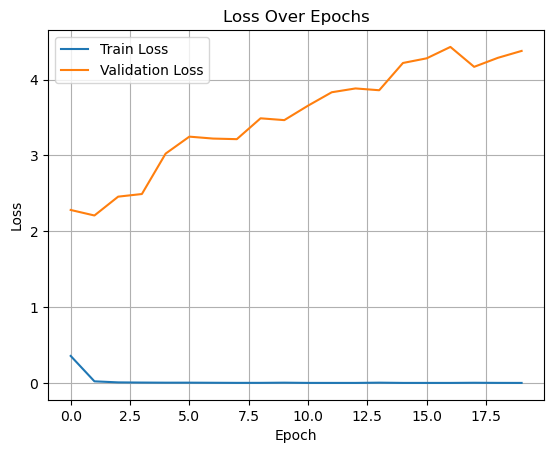

In [37]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
import numpy as np
from sklearn.metrics import accuracy_score

# Step 1: Collect predictions and true labels from test set
y_true = []
y_pred = []

for x_batch, y_batch in test_ds_tf:  # ← test_tf is your tf.data.Dataset
    preds = model.predict(x_batch, verbose=0)
    y_true.extend(y_batch.numpy())
    y_pred.extend(np.argmax(preds, axis=1))  # softmax → class index

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Step 2: Compute and print accuracy for each class
num_classes = 4
for cls in range(num_classes):
    mask = (y_true == cls)
    if np.sum(mask) == 0:
        print(f"Class {cls}: No samples.")
        continue
    acc = accuracy_score(y_true[mask], y_pred[mask])
    print(f"Class {cls} Accuracy: {acc:.3f}")

Class 0 Accuracy: 0.536
Class 1 Accuracy: 0.300
Class 2 Accuracy: 0.834
Class 3 Accuracy: 0.344


In [46]:
y_true.shape

(10000,)

In [48]:
y_pred.shape

(10000,)

In [50]:
y_true = (y_true != 0).astype(int)
y_pred = (y_pred != 0).astype(int)

In [52]:
num_classes = 2
for cls in range(num_classes):
    mask = (y_true == cls)
    if np.sum(mask) == 0:
        print(f"Class {cls}: No samples.")
        continue
    acc = accuracy_score(y_true[mask], y_pred[mask])
    print(f"Class {cls} Accuracy: {acc:.3f}")

Class 0 Accuracy: 0.536
Class 1 Accuracy: 0.880


In [60]:
for i in range (0,10000):
    print(y_pred[i], y_true[i])

1 1
1 1
0 0
1 0
1 1
1 0
1 1
1 1
0 1
1 1
1 0
0 0
1 0
0 0
1 0
1 0
0 0
1 1
1 0
1 1
1 1
1 1
1 1
0 0
1 1
0 1
0 1
0 0
0 0
1 1
1 1
1 1
1 1
0 0
1 0
1 1
1 0
1 0
0 1
0 0
1 1
0 0
1 1
0 1
1 1
1 0
0 0
1 0
1 1
1 0
1 1
1 1
1 1
0 0
0 0
1 1
0 0
1 1
0 0
1 1
1 1
1 1
0 1
1 0
1 1
1 1
1 0
0 1
1 1
1 0
1 1
1 1
1 1
1 1
0 0
1 1
0 1
1 1
0 0
0 0
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 0
1 0
1 1
1 0
0 1
0 1
1 1
0 0
1 1
1 0
1 1
1 0
1 1
0 0
0 0
1 0
1 1
0 0
0 0
0 1
1 1
1 1
0 0
1 0
0 0
1 1
1 1
0 1
1 1
0 0
1 1
0 0
1 1
0 0
1 1
1 1
1 1
1 1
0 0
1 1
0 0
1 1
1 0
1 1
1 1
1 1
1 1
1 1
0 0
1 1
1 1
1 1
1 1
1 1
0 0
1 1
0 1
1 0
1 1
1 0
1 1
1 1
0 1
0 0
1 1
1 1
1 1
0 0
0 0
0 0
1 1
1 1
1 1
0 1
1 1
1 1
1 1
0 1
1 1
1 1
1 1
0 0
1 0
0 0
1 1
1 0
0 1
1 0
1 1
1 0
1 1
1 1
0 0
0 0
1 1
1 1
1 1
1 1
0 1
1 1
0 0
1 1
1 1
0 0
1 1
1 1
1 1
0 1
0 0
1 1
1 0
0 0
1 1
1 0
1 1
1 0
1 0
1 1
1 0
1 1
0 0
1 0
1 1
0 0
1 1
1 1
1 1
1 0
1 0
1 1
1 1
1 1
1 1
1 0
1 1
1 1
0 0
1 1
1 1
1 1
0 0
1 1
1 0
0 0
1 0
0 0
1 1
1 1
0 0
1 1
1 0
1 1
1 1
1 1
1 1
1 1
0 1
1 0
1 1
